In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_S5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Apr  4 16:38:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
| 91%   79C    P0    94W / 250W |      0MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 58%   

In [3]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [4]:
save_dir = '/data/save/model_S5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [5]:
!ls $save_dir

data.json     save_1115000  save_125000   save_177763  save_265000  save_400000
save_100000   save_1120000  save_1250000  save_180000  save_270000  save_600000
save_1000000  save_1125000  save_1255000  save_184582  save_275000  save_710471
save_100189   save_1130000  save_1260000  save_185000  save_280000  save_710898
save_100481   save_1135000  save_1265000  save_185146  save_282023  save_715000
save_1005000  save_1140000  save_1270000  save_190000  save_285000  save_719469
save_100728   save_1140116  save_1275000  save_195000  save_290000  save_720000
save_1010000  save_1145000  save_1280000  save_196835  save_295000  save_725000
save_1015000  save_115000   save_128431   save_199144  save_300000  save_730000
save_1020000  save_1150000  save_1285000  save_200000  save_305000  save_733439
save_1025000  save_1155000  save_1290000  save_201253  save_306501  save_75000
save_1028820  save_1160000  save_1295000  save_205000  save_310000  save_80000
save_1029824  save_1165000  save_130000   

In [6]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams, mode='inference')
model = model.cuda()
step = 1300000

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, _, _ = logger.load(step, model, None)
print(step)

print('done')

Model size 74.6MiB
TTS size 74.6MiB
MelDecoder size 63.6MiB
loaded : 1300000
1300000
done


In [7]:
testset = LJDataset(tts_hparams, split='test')
collate_fn = TextMelCollate(tts_hparams)

test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [8]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

In [9]:
!mkdir inference

mkdir: `inference' 디렉토리를 만들 수 없습니다: 파일이 있습니다


In [48]:
sentences = [
'The Middle Ages brought calligraphy to perfection, and it was natural therefore.',
'that the forms of printed letters should follow more or less closely those of the written character, and they followed them very closely.',
'especially as regards the lower case letters; and type very similar was used during the next fifteen or twenty years not only by Schoeffer,.',
'a very few years saw the birth of Roman character not only in Italy, but in Germany and France.',
'and used an exceedingly beautiful type, which is indeed to look at a transition between Gothic and Roman,.',
'John of Spires and his brother Vindelin, followed by Nicholas Jenson, began to print in that city,.',
'fourteen sixty nine, fourteen seventy;.',
'and though the famous family of Aldus restored its technical excellence, rejecting battered letters,.',
'yet their type is artistically on a much lower level than Jenson\'s, and in fact.',
'they must be considered to have ended the age of fine printing in Italy.',
'Jenson, however, had many contemporaries who used beautiful type,.',
'It must be understood that through the whole of the fifteenth and the first quarter of the sixteenth centuries.',
'Most of Caxton\'s own types are of an earlier character, though they also much resemble Flemish or Cologne letter.',
'the best, mostly French or Low Country, was neat and clear, but without any distinction;.',
'and things got worse and worse through the whole of the seventeenth century, so that in the eighteenth printing was very miserably performed.',
'were the leaders in this luckless change, though our own Baskerville, who was at work some years before them, went much on the same lines;.',
'These and similar founts, cast by the above firm and others,.',
'but the general revival of the old forms has made no way in those countries.',
'which title can only be claimed by artistic practice, whether the art in it be conscious or unconscious.',
'and the elegance and legibility of the ancient more striking than in the Arabic numerals.',
'that he has a five, an eight, or a three before him, unless the press work is of the best:.',
'this is awkward if you have to read Bradshaw\'s Guide in a hurry.',
'this is the narrowing of the modern letters.',
'the lateral compression of his letters renders necessary.',
'In good printing the spaces between the words should be as near as possible equal.',
'it is impossible that they should be quite equal except in lines of poetry.',
'For where these are boldly and carefully designed, and each letter is thoroughly individual in form,.',
'which requires the constant exercise of judgment and taste on the part of the printer.',
'The position of the page on the paper should be considered if the book is to have a satisfactory look.',
'The modern printer, in the teeth of the evidence given by his own eyes, considers the single page as the unit, and prints the page in the middle of his paper.',
'and that laterally the page looks as if it were being driven off the paper.',
'The paper on which the printing is to be done is a necessary part of our subject:.',
'is the habit that publishers have of eking out a thin volume by printing it on thick paper almost of the substance of cardboard,.',
'because the modern practice is to disregard the relation between the printing and the ornament altogether,.',
'so that if the two are helpful to one another it is a mere matter of accident.',
'The due relation of letter to pictures and other ornament was thoroughly understood by the old printers; so that.',
'all books might be at least comely and well looking: and if to these good qualities were added really beautiful ornament and pictures,.',
'Under the conditions referred to in the previous chapter,.',
'The new jail fell as far short of the demands made on it as did the old.',
'Neild gives some figures which well illustrate this.',
'On the fourteenth June, eighteen hundred, there were one hundred ninety nine debtors and two hundred eighty nine felons in the prison.',
'After that they fell as steadily,.',
'who seldom let a session go by without visiting Newgate.',
'In eighteen thirteen.',
'In order to realize the evils entailed by incarceration in Newgate in these days, it is necessary to give some account of its interior.',
'A high wall fifteen feet in height divided the females\' court yard from the men\'s.',
'But these king\'s witnesses were also put at times into the press yard among the capital convicts, seemingly a very dangerous proceeding,.',
'to the various wards their friends occupied.',
'It was large and comparatively commodious, being maintained on a better footing than any other part of the prison.',
'The state side contained twelve good sized rooms,.',
]

In [49]:
for i, sentence in enumerate(sentences):
    print(i, sentence)

0 The Middle Ages brought calligraphy to perfection, and it was natural therefore.
1 that the forms of printed letters should follow more or less closely those of the written character, and they followed them very closely.
2 especially as regards the lower case letters; and type very similar was used during the next fifteen or twenty years not only by Schoeffer,.
3 a very few years saw the birth of Roman character not only in Italy, but in Germany and France.
4 and used an exceedingly beautiful type, which is indeed to look at a transition between Gothic and Roman,.
5 John of Spires and his brother Vindelin, followed by Nicholas Jenson, began to print in that city,.
6 fourteen sixty nine, fourteen seventy;.
7 and though the famous family of Aldus restored its technical excellence, rejecting battered letters,.
8 yet their type is artistically on a much lower level than Jenson's, and in fact.
9 they must be considered to have ended the age of fine printing in Italy.
10 Jenson, however, h

['DH', 'EY1', ' ', 'M', 'AH1', 'S', 'T', ' ', 'B', 'IY1', ' ', 'K', 'AH0', 'N', 'S', 'IH1', 'D', 'ER0', 'D', ' ', 'T', 'UW1', ' ', 'HH', 'AE1', 'V', ' ', 'EH1', 'N', 'D', 'AH0', 'D', ' ', 'DH', 'AH0', ' ', 'EY1', 'JH', ' ', 'AH1', 'V', ' ', 'F', 'AY1', 'N', ' ', 'P', 'R', 'IH1', 'N', 'T', 'IH0', 'NG', ' ', 'IH0', 'N', ' ', 'IH1', 'T', 'AH0', 'L', 'IY0', ' ', '.']
[ 0 68 72 69 89 49 32 77 65 72 49 83 84 32 66 73 89 49 32 75 65 72 48 78
 83 73 72 49 68 69 82 48 68 32 84 85 87 49 32 72 72 65 69 49 86 32 69 72
 49 78 68 65 72 48 68 32 68 72 65 72 48 32 69 89 49 74 72 32 65 72 49 86
 32 70 65 89 49 78 32 80 82 73 72 49 78 84 73 72 48 78 71 32 73 72 48 78
 32 73 72 49 84 65 72 48 76 73 89 48 32 46  0]
0.0281522274017334


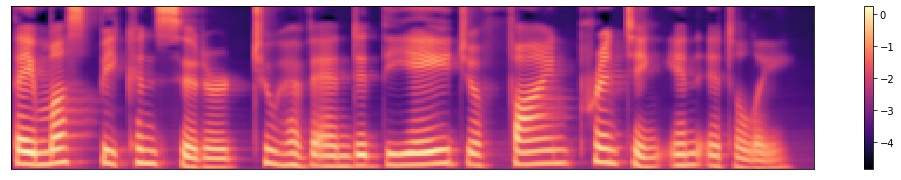

(87552,)


In [33]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 
import soundfile as sf
from g2p_en import G2p
g2p = G2p()

t0 = time.time()
# text = "In this study, we propose a text to speech model, referred to as Kimchi Speech, "
# text += "which has a hierarchical V A E structure and uses a attention alignment obtained from a speech to text model. "
# text += "The hierarchical V A E structure contributes to the generation of high quality outputs and a variety of prosody. "
# text += "Because the S T T model operates independently of the T T S model, the attention alignment can be obtained robustly. "
# text += "Moreover, the speed of a generated speech can be flexibly controlled by soft attention using Gaussian distributions. "
# text += "Furthermore, we propose two configurations of the model, namely Kimchi Speech W and Kimchi Speech S ."
# text += "The former is a light version that has only 3.3 million parameters for inference, whereas the latter is a fast version that produces outputs 470 times faster than real time on a G P U. "
# text += "The mean opinion score results show that the outputs are of state of the art quality."
text = "they must be considered to have ended the age of fine printing in Italy."
text_array = g2p(text)
print(text_array)
text = ""
for t in text_array:
    text += t
 
text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
print(utf8_values)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():
    
    samples, time_dict = model.inference(t, None, None, temperature=1, clip=1, speed=1.0)
    _s = samples.data.cpu().numpy()
    t1 = time.time()
    print(t1 - t0)
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    sf.write('inference_9_S5G1.wav', _wav, 22050, subtype='PCM_16')
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

In [33]:
!mkdir inference/exp5
!mkdir inference/exp5/S5GN
!ls inference/exp5/S5GN

mkdir: `inference/exp5' 디렉토리를 만들 수 없습니다: 파일이 있습니다
mkdir: `inference/exp5/S5GN' 디렉토리를 만들 수 없습니다: 파일이 있습니다
inference_0_S5GN.wav   inference_25_S5GN.wav  inference_40_S5GN.wav
inference_10_S5GN.wav  inference_26_S5GN.wav  inference_41_S5GN.wav
inference_11_S5GN.wav  inference_27_S5GN.wav  inference_42_S5GN.wav
inference_12_S5GN.wav  inference_28_S5GN.wav  inference_43_S5GN.wav
inference_13_S5GN.wav  inference_29_S5GN.wav  inference_44_S5GN.wav
inference_14_S5GN.wav  inference_2_S5GN.wav   inference_45_S5GN.wav
inference_15_S5GN.wav  inference_30_S5GN.wav  inference_46_S5GN.wav
inference_16_S5GN.wav  inference_31_S5GN.wav  inference_47_S5GN.wav
inference_17_S5GN.wav  inference_32_S5GN.wav  inference_48_S5GN.wav
inference_18_S5GN.wav  inference_33_S5GN.wav  inference_49_S5GN.wav
inference_19_S5GN.wav  inference_34_S5GN.wav  inference_4_S5GN.wav
inference_1_S5GN.wav   inference_35_S5GN.wav  inference_5_S5GN.wav
inference_20_S5GN.wav  inference_36_S5GN.wav  inference_6_S5GN.wav
inference_21_S

In [55]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 
import soundfile as sf
from g2p_en import G2p

g2p = G2p()

temperature = 1.0
clip = 3
tag = 'S5G3'
inference_dir = 'inference/exp5/' + tag + '/'
!mkdir $inference_dir

model.eval()
vocoder.eval()
with torch.no_grad():
    for i, sentence in enumerate(sentences[:50]):
        if i != 23:
            continue
        print(i, sentence)
        
        text = sentence
        text_array = g2p(text)
        text = ""
        for t in text_array:
            text += t

        text_utf = text.encode()
        ts = [0]
        for t in text_utf:
            ts.append(t)
        ts.append(0)    
        utf8_values = np.array(ts)
        t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
        model.eval()
        with torch.no_grad():

            samples, time_dict = model.inference(t, None, None, temperature=temperature, clip=clip)
            _s = samples.data.cpu().numpy()

        _mel = _s[0].T
        _mel = (_mel - mean) / scale
        mel = torch.from_numpy(_mel).cuda()
        wav = vocoder.inference(mel)
        _wav = wav[:, 0].data.cpu().numpy()
        save_path = inference_dir + 'inference_' + str(i) + '_' + tag + '.wav'
        sf.write(save_path, _wav, 22050, subtype='PCM_16')
        
print('done')

mkdir: `inference/exp5/S5G3/' 디렉토리를 만들 수 없습니다: 파일이 있습니다
23 the lateral compression of his letters renders necessary.
TruncatedNormal 3
TruncatedNormal 3
TruncatedNormal 3
TruncatedNormal 3
TruncatedNormal 3
done


## Speed

In [31]:
sentences = [
"Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition",
"in being comparatively modern.",
"For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process",
"produced the block books, which were the immediate predecessors of the true printed book,",
"the invention of movable metal letters in the middle of the fifteenth century may justly be considered as the invention of the art of printing.",
"And it is worth mention in passing that, as an example of fine typography,",
"the earliest book printed with movable types, the Gutenberg, or forty-two line Bible of about fourteen fifty-five,",
"has never been surpassed.",
"Printing, then, for our purpose, may be considered as the art of making books by means of movable types.",
"Now, as all books not primarily intended as picture-books consist principally of types composed to form letterpress,",
"it is of the first importance that the letter used should be fine in form;",
"especially as no more time is occupied, or cost incurred, in casting, setting, or printing beautiful letters",
"than in the same operations with ugly ones.",
"And it was a matter of course that in the Middle Ages, when the craftsmen took care that beautiful form should always be a part of their productions whatever they were,",
"the forms of printed letters should be beautiful, and that their arrangement on the page should be reasonable and a help to the shapeliness of the letters themselves.",
"The Middle Ages brought calligraphy to perfection, and it was natural therefore",
"that the forms of printed letters should follow more or less closely those of the written character, and they followed them very closely.",
"The first books were printed in black letter, i.e. the letter which was a Gothic development of the ancient Roman character,",
"and which developed more completely and satisfactorily on the side of the lower-case than the capital letters;",
"the lower-case being in fact invented in the early Middle Ages.",
"The earliest book printed with movable type, the aforesaid Gutenberg Bible, is printed in letters which are an exact imitation",
"of the more formal ecclesiastical writing which obtained at that time; this has since been called missal type,",
"and was in fact the kind of letter used in the many splendid missals, psalters, etc., produced by printing in the fifteenth century.",
"But the first Bible actually dated (which also was printed at Maintz by Peter Schoeffer in the year fourteen sixty-two)",
"imitates a much freer hand, simpler, rounder, and less spiky, and therefore far pleasanter and easier to read.",
"On the whole the type of this book may be considered the ne-plus-ultra of Gothic type,",
"especially as regards the lower-case letters; and type very similar was used during the next fifteen or twenty years not only by Schoeffer,",
"but by printers in Strasburg, Basle, Paris, Lubeck, and other cities.",
"But though on the whole, except in Italy, Gothic letter was most often used",
"a very few years saw the birth of Roman character not only in Italy, but in Germany and France.",
"In fourteen sixty-five Sweynheim and Pannartz began printing in the monastery of Subiaco near Rome,",
"and used an exceedingly beautiful type, which is indeed to look at a transition between Gothic and Roman,",
"but which must certainly have come from the study of the twelfth or even the eleventh century MSS.",
"They printed very few books in this type, three only; but in their very first books in Rome, beginning with the year fourteen sixty-eight,",
"they discarded this for a more completely Roman and far less beautiful letter.",
"But about the same year Mentelin at Strasburg began to print in a type which is distinctly Roman;",
"and the next year Gunther Zeiner at Augsburg followed suit;",
"while in fourteen seventy at Paris Udalric Gering and his associates turned out the first books printed in France, also in Roman character.",
"The Roman type of all these printers is similar in character,",
"and is very simple and legible, and unaffectedly designed for use; but it is by no means without beauty.",
"It must be said that it is in no way like the transition type of Subiaco,",
"and though more Roman than that, yet scarcely more like the complete Roman type of the earliest printers of Rome.",
"A further development of the Roman letter took place at Venice.",
"John of Spires and his brother Vindelin, followed by Nicholas Jenson, began to print in that city,",
"fourteen sixty-nine, fourteen seventy;",
"their type is on the lines of the German and French rather than of the Roman printers.",
"Of Jenson it must be said that he carried the development of Roman type as far as it can go:",
"his letter is admirably clear and regular, but at least as beautiful as any other Roman type.",
"After his death in the fourteen eighties, or at least by fourteen ninety, printing in Venice had declined very much;",
"and though the famous family of Aldus restored its technical excellence, rejecting battered letters,",
"and paying great attention to the press work or actual process of printing,",
"yet their type is artistically on a much lower level than Jenson's, and in fact",
"they must be considered to have ended the age of fine printing in Italy.",
"Jenson, however, had many contemporaries who used beautiful type,",
"some of which -- as, e.g., that of Jacobus Rubeus or Jacques le Rouge -- is scarcely distinguishable from his.",
"It was these great Venetian printers, together with their brethren of Rome, Milan,",
"Parma, and one or two other cities, who produced the splendid editions of the Classics, which are one of the great glories of the printer's art,",
"and are worthy representatives of the eager enthusiasm for the revived learning of that epoch. By far,",
"the greater part of these Italian printers, it should be mentioned, were Germans or Frenchmen, working under the influence of Italian opinion and aims.",
"It must be understood that through the whole of the fifteenth and the first quarter of the sixteenth centuries",
"the Roman letter was used side by side with the Gothic.",
"Even in Italy most of the theological and law books were printed in Gothic letter,",
"which was generally more formally Gothic than the printing of the German workmen,",
"many of whose types, indeed, like that of the Subiaco works, are of a transitional character.",
"This was notably the case with the early works printed at Ulm, and in a somewhat lesser degree at Augsburg.",
"In fact Gunther Zeiner's first type (afterwards used by Schussler) is remarkably like the type of the before-mentioned Subiaco books.",
"In the Low Countries and Cologne, which were very fertile of printed books, Gothic was the favorite.",
"The characteristic Dutch type, as represented by the excellent printer Gerard Leew, is very pronounced and uncompromising Gothic.",
"This type was introduced into England by Wynkyn de Worde, Caxton's successor,",
"and was used there with very little variation all through the sixteenth and seventeenth centuries, and indeed into the eighteenth.",
"Most of Caxton's own types are of an earlier character, though they also much resemble Flemish or Cologne letter.",
"After the end of the fifteenth century the degradation of printing, especially in Germany and Italy,",
"went on apace; and by the end of the sixteenth century there was no really beautiful printing done:",
"the best, mostly French or Low-Country, was neat and clear, but without any distinction;",
"the worst, which perhaps was the English, was a terrible falling-off from the work of the earlier presses;",
"and things got worse and worse through the whole of the seventeenth century, so that in the eighteenth printing was very miserably performed.",
"In England about this time, an attempt was made (notably by Caslon, who started business in London as a type-founder in seventeen twenty)",
"to improve the letter in form.",
"Caslon's type is clear and neat, and fairly well designed;",
"he seems to have taken the letter of the Elzevirs of the seventeenth century for his model:",
"type cast from his matrices is still in everyday use.",
"In spite, however, of his praiseworthy efforts, printing had still one last degradation to undergo.",
"The seventeenth century founts were bad rather negatively than positively.",
"But for the beauty of the earlier work they might have seemed tolerable.",
"It was reserved for the founders of the later eighteenth century to produce letters which are positively ugly, and which, it may be added,",
"are dazzling and unpleasant to the eye owing to the clumsy thickening and vulgar thinning of the lines:",
"for the seventeenth-century letters are at least pure and simple in line. The Italian, Bodoni, and the Frenchman, Didot,",
"were the leaders in this luckless change, though our own Baskerville, who was at work some years before them, went much on the same lines;",
"but his letters, though uninteresting and poor, are not nearly so gross and vulgar as those of either the Italian or the Frenchman.",
"With this change the art of printing touched bottom,",
"so far as fine printing is concerned, though paper did not get to its worst till about eighteen forty.",
"The Chiswick press in eighteen forty-four revived Caslon's founts, printing for Messrs. Longman the Diary of Lady Willoughby.",
"This experiment was so far successful that about eighteen fifty Messrs. Miller and Richard of Edinburgh",
"were induced to cut punches for a series of old style letters.",
"These and similar founts, cast by the above firm and others,",
"have now come into general use and are obviously a great improvement on the ordinary modern style in use in England, which is in fact the Bodoni type",
"a little reduced in ugliness. The design of the letters of this modern old style leaves a good deal to be desired,",
"and the whole effect is a little too gray, owing to the thinness of the letters.",
"It must be remembered, however, that most modern printing is done by machinery on soft paper, and not by the hand press,",
"and these somewhat wiry letters are suitable for the machine process, which would not do justice to letters of more generous design.",
"It is discouraging to note that the improvement of the last fifty years is almost wholly confined to Great Britain.",
"Here and there a book is printed in France or Germany with some pretension to good taste,",
"but the general revival of the old forms has made no way in those countries.",
"Italy is contentedly stagnant.",
"America has produced a good many showy books, the typography, paper, and illustrations of which are, however, all wrong,",
"oddity rather than rational beauty and meaning being apparently the thing sought for both in the letters and the illustrations.",
"To say a few words on the principles of design in typography:",
"it is obvious that legibility is the first thing to be aimed at in the forms of the letters;",
"this is best furthered by the avoidance of irrational swellings and spiky projections, and by the using of careful purity of line.",
"Even the Caslon type when enlarged shows great shortcomings in this respect:",
"the ends of many of the letters such as the t and e are hooked up in a vulgar and meaningless way,",
"instead of ending in the sharp and clear stroke of Jenson's letters;",
"there is a grossness in the upper finishings of letters like the c, the a, and so on,",
"an ugly pear-shaped swelling defacing the form of the letter:",
"in short, it happens to this craft, as to others, that the utilitarian practice, though it professes to avoid ornament,",
"still clings to a foolish, because misunderstood conventionality, deduced from what was once ornament, and is by no means useful;",
"which title can only be claimed by artistic practice, whether the art in it be conscious or unconscious.",
"In no characters is the contrast between the ugly and vulgar illegibility of the modern type",
"and the elegance and legibility of the ancient more striking than in the Arabic numerals.",
"In the old print each figure has its definite individuality, and one cannot be mistaken for the other;",
"in reading the modern figures the eyes must be strained before the reader can have any reasonable assurance",
"that he has a five, an eight, or a three before him, unless the press work is of the best:",
"this is awkward if you have to read Bradshaw's Guide in a hurry.",
"One of the differences between the fine type and the utilitarian must probably be put down to a misapprehension of a commercial necessity:",
"this is the narrowing of the modern letters.",
"Most of Jenson's letters are designed within a square,",
"the modern letters are narrowed by a third or thereabout; but while this gain of space very much hampers the possibility of beauty of design,",
"it is not a real gain, for the modern printer throws the gain away by putting inordinately wide spaces between his lines, which, probably,",
"the lateral compression of his letters renders necessary.",
"Commercialism again compels the use of type too small in size to be comfortable reading:",
"the size known as Long primer ought to be the smallest size used in a book meant to be read.",
"Here, again, if the practice of leading were retrenched larger type could be used without enhancing the price of a book.",
"One very important matter in setting up for fine printing is the spacing, that is, the lateral distance of words from one another.",
"In good printing the spaces between the words should be as near as possible equal",
"it is impossible that they should be quite equal except in lines of poetry",
"modern printers understand this, but it is only practiced in the very best establishments.",
"But another point which they should attend to they almost always disregard;",
"this is the tendency to the formation of ugly meandering white lines or rivers in the page",
"a blemish which can be nearly, though not wholly, avoided by care and forethought",
"the desirable thing being the breaking of the line as in bonding masonry or brickwork",
"The general solidity of a page is much to be sought for",
"modern printers generally overdo the whites in the spacing, a defect probably forced on them by the characterless quality of the letters.",
"For where these are boldly and carefully designed, and each letter is thoroughly individual in form,",
"the words may be set much closer together, without loss of clearness.",
"No definite rules, however, except the avoidance of rivers and excess of white, can be given for the spacing,",
"which requires the constant exercise of judgment and taste on the part of the printer.",
"The position of the page on the paper should be considered if the book is to have a satisfactory look.",
"Here once more the almost invariable modern practice is in opposition to a natural sense of proportion.",
"From the time when books first took their present shape till the end of the sixteenth century, or indeed later,",
"the page so lay on the paper that there was more space allowed to the bottom and fore margin than to the top and back of the paper,",
"the unit of the book being looked on as the two pages forming an opening.",
"The modern printer, in the teeth of the evidence given by his own eyes, considers the single page as the unit, and prints the page in the middle of his paper",
"only nominally so, however, in many cases, since when he uses a headline he counts that in,",
"the result as measured by the eye being that the lower margin is less than the top one, and that the whole opening has an upside-down look vertically",
"and that laterally the page looks as if it were being driven off the paper.",
"The paper on which the printing is to be done is a necessary part of our subject:",
"of this it may be said that though there is some good paper made now,",
"it is never used except for very expensive books, although it would not materially increase the cost in all but the very cheapest.",
"The paper that is used for ordinary books is exceedingly bad even in this country, but is beaten in the race for vileness",
"by that made in America, which is the worst conceivable.",
"There seems to be no reason why ordinary paper should not be better made,",
"even allowing the necessity for a very low price; but any improvement must be based on showing openly that the cheap article is cheap,",
"e.g. the cheap paper should not sacrifice toughness and durability to a smooth and white surface,",
"which should be indications of a delicacy of material and manufacture which would of necessity increase its cost.",
"One fruitful source of badness in paper",
"is the habit that publishers have of eking out a thin volume by printing it on thick paper almost of the substance of cardboard,",
"a device which deceives nobody, and makes a book very unpleasant to read.",
"On the whole, a small book should be printed on paper which is as thin as may be without being transparent.",
"The paper used for printing the small highly ornamented French service-books about the beginning of the sixteenth century is a model in this respect,",
"being thin, tough, and opaque.",
"However, the fact must not be blinked that machine-made paper cannot in the nature of things be made of so good a texture as that made by hand.",
"The ornamentation of printed books is too wide a subject to be dealt with fully here; but one thing must be said on it.",
"The essential point to be remembered is that the ornament, whatever it is, whether picture or pattern-work, should form part of the page,",
"should be a part of the whole scheme of the book.",
"Simple as this proposition is, it is necessary to be stated,",
"because the modern practice is to disregard the relation between the printing and the ornament altogether,",
"so that if the two are helpful to one another it is a mere matter of accident.",
"The due relation of letter to pictures and other ornament was thoroughly understood by the old printers; so that",
"even when the woodcuts are very rude indeed,",
"the proportions of the page still give pleasure by the sense of richness that the cuts and letter together convey.",
"When, as is most often the case, there is actual beauty in the cuts,",
"the books so ornamented are amongst the most delightful works of art that have ever been produced.",
"Therefore, granted well-designed type, due spacing of the lines and words, and proper position of the page on the paper,",
"all books might be at least comely and well-looking: and if to these good qualities were added really beautiful ornament and pictures,",
"printed books might once again illustrate to the full",
"the position of our Society that a work of utility might be also a work of art, if we cared to make it so.",
"The Chronicles of Newgate, Volume two. By Arthur Griffiths. Section four: Newgate down to eighteen eighteen.",
"Under the conditions referred to in the previous chapter,",
"with criminals and misdemeanants of all shades crowding perpetually into its narrow limits, the latter state of Newgate was worse than the first.",
"The new jail fell as far short of the demands made on it as did the old.",
"The prison population fluctuated a great deal,",
"but it was almost always in excess of the accommodation available, and there were times when the place was full to overflowing.",
"Neild gives some figures which well illustrate this.",
"On the fourteenth June, eighteen hundred, there were one hundred ninety-nine debtors and two hundred eighty-nine felons in the prison.",
"On the twenty-seventh April, in the following year,",
"these numbers had risen to two hundred seventy-five and three hundred seventy-five respectively, or six hundred fifty in all.",
"For two more years these high figures were steadily maintained, and in eighteen oh three the total rose to seven hundred ten.",
"After that they fell as steadily,",
"till, eighteen oh eight, the lowest point was touched of one hundred ninety-seven debtors and one hundred eighty-two felons, or three hundred seventy-nine in all.",
"The numbers soon increased, however, and by eighteen eleven had again risen to six hundred twenty-nine; and Mr. Neild was told that there had been at one time",
"three hundred debtors and nine hundred criminals in Newgate, or twelve hundred prisoners in all.",
"Previous to that date there had been seven hundred or eight hundred frequently, and once, in Mr. Akerman's time, one thousand.",
"Trustworthy evidence is forthcoming to the effect that these high figures were constantly maintained for many months at a time.",
"The inadequacy of the jail was noticed and reported upon again and again by the grand juries of the city of London,",
"who seldom let a session go by without visiting Newgate.",
"In eighteen thirteen",
"the grand jury made a special presentment to the Court of Common Council, pointing out that on the debtors' side, which was intended for only one hundred,",
"no less than three hundred forty were crowded, to the great inconvenience and danger of the inmates.",
"On the female side matters were much worse;",
"Quote. the apartments set apart for them, being built to accommodate sixty persons, now contain about one hundred twenty. End quote.",
"Returns laid before the House of Commons showed that six thousand, four hundred thirty-nine persons had been committed to Newgate",
"in the three years between eighteen thirteen and eighteen sixteen,",
"and this number did not include the debtors, a numerous class, who were still committed to Newgate pending the completion of the White Cross Street prison.",
"In order to realize the evils entailed by incarceration in Newgate in these days, it is necessary to give some account of its interior",
"as it was occupied and appropriated in eighteen ten.",
"Full details of the arrangements are to be found in Mr. Neild's State of Prisons in England, Scotland, and Wales, published in eighteen twelve.",
"The jail at that date was divided into eight separate and more or less distinct departments, each of which had its own wards and yard.",
"These were: one. The male debtors' side.",
"two. The female debtors' side. three. The chapel yard. four. The middle yard.",
"five. The master felons' side. six. The female felons' side. seven. The state side.",
"eight. The press yard.",
"one. The male debtors' side consisted of a yard forty-nine feet by thirty-one,",
"leading to thirteen wards on various floors, and a day room.",
"Of these wards, three were appropriated to the cabin side, so called because",
"they each contained four small rooms or cabins seven feet square,",
"intended to accommodate a couple of prisoners apiece, but often much more crowded.",
"Two other wards were appropriated to the master's side debtors; they were each twenty-three feet by fourteen and a half,",
"and supposed to accommodate twenty persons. The eight remaining wards were for the common side debtors,",
"long narrow rooms -- one thirty-six feet, six twenty-three feet, and the eighth eighteen,",
"the whole about fifteen feet wide.",
"The various wards were all about eleven feet in height,",
"and were occupied as a rule by ten to fifteen people when the prison was not crowded, but double the number was occasionally placed in them.",
"The day room was fitted with benches and settles after the manner of the tap in a public-house.",
"two. The female debtors' side consisted of a court-yard forty-nine by sixteen feet,",
"leading to two wards, one of which was thirty-six feet by fifteen,",
"and the other eighteen by fifteen; and they nominally held twenty-two persons.",
"A high wall fifteen feet in height divided the females' court-yard from the men's.",
"three. The chapel yard was about forty-three feet by twenty-five.",
"It had been for some time devoted principally to felons of the worst types,",
"those who were the oldest offenders, sentenced to transportation, and who had narrowly escaped the penalty of death.",
"This arrangement was, however, modified after eighteen eleven, and the chapel yard was allotted to misdemeanants and prisoners awaiting trial.",
"The wards in this part were five in number, all in dimensions twenty feet by fifteen, with a sixth ward fifteen feet square.",
"These wards were all fitted with barrack-beds, but no bedding was supplied.",
"The chapel yard led to the chapel, and on the staircase were two rooms frequently set apart for the king's witnesses,",
"those who had turned king's evidence, whose safety might have been imperiled had they been lodged with the men against whom they had informed.",
"But these king's witnesses were also put at times into the press yard among the capital convicts, seemingly a very dangerous proceeding,",
"or they lodged with the gatesmen, the prisoner officers who had charge of the inner gates.",
"The middle yard was at first given up to the least heinous offenders. After eighteen twelve it changed functions with the chapel yard.",
"It was fifty feet by twenty-five, and had five wards each thirty-eight by fifteen. At one end of the yard was an arcade,",
"directly under the chapel, in which there were three cells, used either for the confinement of disorderly and refractory prisoners,",
"or female convicts ordered for execution.",
"The master felons' side consisted of a yard the same size as the preceding, appropriated nominally to the most decent and better-behaved prisoners,",
"but really kept for the few who had funds sufficient to gain them admission to these more comfortable quarters.",
"Here were also lodged the gatesmen, the prisoners who had charge of the inner gates, and who were entrusted with the duty of escorting visitors from the gates",
"to the various wards their friends occupied.",
"The state side was the part stolen from the female felons' side.",
"It was large and comparatively commodious, being maintained on a better footing than any other part of the prison.",
"The inmates were privileged, either by antecedents or the fortunate possession of sufficient funds to pay the charges of the place.",
"Neild takes it for granted that the former rather than the latter prevailed in the selection,",
"and tells us that in the state side, quote, such prisoners were safely associated whose manners and conduct evince a more liberal style of education,",
"and who are therefore lodged apart from all other districts of the jail. End quote.",
"The state side contained twelve good-sized rooms,",
"from twenty-one by eighteen feet to fifteen feet square, which were furnished with bedsteads and bedding.",
"seven. The press yard was that part set aside for the condemned.",
"Its name and its situation were the same as those of the old place of carrying out the terrible sentence inflicted on accused persons who stood mute.",
"The long narrow yard still remained as we saw it in Jacobite times,",
"and beyond it was now a day room for the capital convicts or those awaiting execution.",
"Beyond the press yard were three stories, condemned cells, fifteen in all, with vaulted ceilings nine feet high to the crown of the arch.",
"The ground floor cells were nine feet by six;",
"those on the first floor were rather larger on account of a set-off in the wall; and the uppermost were the largest, for the same reason.",
"Security was provided for in these condemned cells by lining the substantial stone walls with planks studded with broad-headed nails;",
"they were lighted by a double-grated window two feet nine inches by fourteen inches; and in the doors, which were four inches thick,",
"a circular aperture had been let in to give ventilation and secure a free current of air.",
"In each cell there was a barrack bedstead on the floor without bedding.",
"eight. The female felons were deprived of part of the space which the architect had intended for them.",
"More than half their quadrangle had been partitioned off for another purpose,",
"and what remained was divided into a master's and a common side for female felons.",
"The two yards were adjoining, that for the common side much the largest.",
"There were nine wards in all on the female side, one of them in the attic,",
"with four casements and two fireplaces, being allotted for a female infirmary",
"and the rest being provided with barrack beds, and in dimensions varying from thirty feet by fifteen to fifteen feet by ten.",
"The eight courts above enumerated were well supplied with water;",
"they had dust-bins, sewers, and so forth, properly disposed, and the city scavenger paid periodical visits to the prison.",
"The prisoners had few comforts, beyond the occasional use of a bath at some distance, situated in the press yard,",
"to which access was granted rarely and as a great favor. But they were allowed the luxury of drink -- if they could pay for it.",
"A recent reform had closed the tap kept by the jailer within the precincts, but",
"there was still a convenient room which served, and, quote,",
"near it a grating through which the debtors receive their beer from the neighboring public-houses.",
"The felons' side has a similar accommodation, and this mode of introducing the beverage is adopted because no publican as such",
"can be permitted to enter the interior of this prison. End quote. The tap-room and bar were just behind the felons' entrance lodge,",
"and beyond it was a room called the wine room, because formerly used for the sale of wine, but",
"in which latterly a copper had been fixed for the cooking of provisions sent in by charitable persons.",
"Quote, On the top of the jail, continues Neild, are a watch-house and a sentry-box, where two or more guards, with dogs and firearms,",
"watch all night. Adjoining the felons' side lodge is the keeper's office, where the prison books are kept, and his clerk,",
"called the clerk of the papers, attends daily. End quote.",
"Having thus briefly described the plan and appropriation of the prison, I propose to deal now with the general condition of the inmates, and the manner of their life.",
"Of these the debtors, male and female, formed a large proportion.",
"The frequency and extent of processes against debtors seventy or eighty years ago will appear almost incredible",
"in an age when insolvent acts and bankruptcy courts do so much to relieve the impecunious,",
"and imprisonment for debt has almost entirely disappeared.",
"The number of processes against debtors annually was extraordinary.",
"Neild gives, on the authority of Mr. Burchell, the under sheriff of Middlesex,",
"a table showing the figures for the year ending Michaelmas eighteen oh two.",
"In that period upwards of two hundred thousand writs",
"had been issued for the arrests of debtors in the kingdom, for sums varying from fourpence to five hundred pounds and upwards.",
"Fifteen thousand of these were issued in Middlesex alone, which at that time was reckoned as only a fifteenth of Great Britain.",
"The number of arrests actually made was one hundred fourteen thousand, three hundred for the kingdom, and seven thousand twenty for Middlesex.",
"Barely half of these gave bail bonds on arrests, and the remainder went to prison.",
"Quite half of the foregoing writs and arrests applied to sums under thirty pounds.",
"Neild also says that in seventeen ninety-three,",
"five thousand, seven hundred nineteen writs and executions for debts between ten pounds and twenty pounds were issued in Middlesex,",
"and the aggregate amount of debts sued for was eighty-one thousand, seven hundred ninety-one pounds.",
"He also makes the curious calculation that the costs of these actions if undefended",
"would have amounted to sixty-eight thousand, seven hundred twenty-eight pounds, and if defended,",
"two hundred eighty-five thousand, nine hundred fifty pounds; in other words, that to recover eighty odd thousand pounds,",
"three times the amount would be expended.",
"An elaborate machinery planned for the protection of the trader, and altogether on his side, had long existed for the recovery of debts.",
"Alfred the Great established the Court Baron, the Hundred Court, and the County Court, which among other matters entertained pleas for debt.",
"The County Court was the sheriff's, who sat there surrounded by the bishop and the magnates of the county;",
"but as time passed, difficulties and delays in obtaining judgment led to the removal of causes to the great Court of King's Bench,",
"and the disuse of the inferior courts.",
"So much inconvenience ensued, that in fifteen eighteen the Corporation obtained from Parliament an act empowering two aldermen",
"and four common councilmen to hold Courts of Requests, or Courts of Conscience, to hear and determine all causes of debt",
"under forty shillings arising within the city.",
"These courts were extended two centuries later to several large provincial towns, and all were in full activity when Neild wrote,",
"and indeed supplied the bulk of the poor debtors committed to prison.",
"These courts were open to many and grave objections.",
"The commissioners who presided were, quote, little otherwise than self-elected",
"and when once appointed continued to serve sine die; they were generally near in rank to the parties whose causes they decided.",
"Often a commissioner had to leave the bench because he was himself a party to the suit that was sub judice.",
"The activity as well as the futility of these courts may be estimated from the statement given by Neild",
"that thirteen hundred and twelve debtors were committed by them to Newgate between seventeen ninety-seven and eighteen oh eight,",
"and that no more than one hundred ninety-seven creditors recovered debts and costs.",
"The latter indeed hung like millstones round the neck of the unhappy insolvent wretches who found themselves in limbo.",
"Costs were the gallons of sack to the pennyworth of debt.",
"Neild found at his visit to Newgate in eighteen ten,",
"fourteen men and women who had lain there ten, eleven, and thirteen years for debts of a few shillings,",
"weighted by treble the amount of costs.",
"Thus, amongst others, Thomas Blackburn had been committed on October fifteenth for a debt of one shilling five pence.",
"for which the costs were six shillings ten pence.",
"Thomas Dobson, on twenty-second August, seventeen ninety-nine, for one shilling, with costs of eight shillings, ten pence.",
"and Susannah Evans, in October the same year, for two shillings, with costs of six shillings, eight pence.",
"Other cases are recorded elsewhere, as at the Giltspur Street Compter, where in eighteen oh five Mr. Neild found a man named William Grant",
"detained for one shilling nine pence, with costs of five shillings.",
"and John Lancaster for one shilling, eight pence, with costs of seven shillings, six pence. Quote.",
"These surely, I thought, says Mr. Neild, were bad enough! But it was not so. End quote.",
"He recites another most outrageous and extraordinary case, in which one John Bird,",
"a market porter, was arrested and committed at the suit of a publican",
"for the paltry sum of four pence, with costs of seven shillings, six pence.",
"Bird was, however, discharged within three days by a subscription raised among his fellow-prisoners.",
"Mr. Buxton, in his Inquiry into the System of Prison Discipline,",
"quotes a case which came within his own knowledge of a boy sent to prison for non-payment of one penny.",
"The lad in question was found in Coldbath Fields prison, to which he had been sent for a month in default of paying a fine of forty shillings.",
"He had been in the employ of a corn-chandler at Islington, and went into London with his master's cart and horse.",
"There was in the City Road a temporary bar, with a collector of tolls who was sometimes on the spot and sometimes not.",
"The boy declared he saw no one, and accordingly passed through without paying the toll of a penny.",
"For this he was summoned before a magistrate, and sentenced as already stated.",
"The lad was proved to be of good character and the son of respectable parents.",
"Mr. Buxton's friends at once paid the forty shillings, and the boy was released.",
"The costs in heavier debts always doubled the sum; if the arrest was made in the country it trebled it.",
"Neild gives a list of the various items charged upon a debt of ten pounds, which included instructions to sue,",
"affidavit of debt, drawing praecipe (one pound, five shillings), capias, fee to officer on arrest,",
"affidavit of service, and many more, amounting in all to twenty-seven,",
"and costing eleven pounds, fifteen shillings, eight pence, within ten days.",
"Before dealing with the debtors in Newgate, I may refer incidentally",
"to those in other London prisons, for Newgate was not the only place of durance for these unfortunate people. There were also the King's Bench,",
"the Fleet, and the Marshalsea prisons especially devoted to them,",
"whilst Ludgate, the Giltspur Street, and Borough Compters also received them",
"the latter two being also a prison for felons and vagrants arrested within certain limits.",
"The King's Bench was a national prison, in which were confined all debtors arrested for debt or for contempt of the court of the King's Bench.",
"The population generally amounted to from five hundred to seven hundred, the accommodation being calculated for two hundred.",
"Every new-comer was entitled to a chummage ticket, but did not always get it,",
"being often obliged to pay a high rent for a bed at the coffee-house or in some room which was vacated by its regular occupant.",
"No fixed rates or rules governed the hiring out of rooms or parts of a room, and all sorts of imposition was practiced.",
"The best, or at least the most influential prisoners, got lodging in the State House, which contained eight large handsome rooms.",
"Besides those actually resident within the walls,",
"another two hundred more or less took advantage of the rules, and lived outside within a circumference of two miles and a half.",
"In these cases security was given for the amount of the debt,",
"and a heavy fee at the rate of eight pounds per one hundred pounds, with four pounds for every additional hundred.",
"Besides these, a number had the privilege of a run on the key, which allowed a prisoner to go into the rules for the day.",
"The foregoing rentals and payments for privileges, together with fees exacted on commitment and discharge, went to the marshal or keeper of the prison,",
"whose net annual income thus entirely derived from the impecunious amounted to between three and four thousand pounds.",
"The office of marshal had been hereditary,",
"but in the twenty-seventh George the second the right of presentation was bought by the Crown for ten thousand, five hundred pounds.",
"The marshal was supposed to be resident either within the prison or the rules.",
"He seems to have felt no responsibility as to the welfare or comfort of those in charge, and out of whom he made all his money.",
"The prison was always in the most filthy state imaginable.",
"The half or wholly starved prisoners fished for alms or food at the gratings.",
"When they were sick no more notice was taken of them than of a dog.",
"A man dying of liver complaint lay on the cold stones without a bed or food to eat.",
"Dissolute habits prevailed on all sides; drunkenness was universal, gambling perpetual.",
"The yards were taken up with rackets and five courts, and here and there were bumble puppy grounds, a game in which the players rolled iron balls",
"into holes marked with numbers.",
"How to make most profit out of the wretched denizens of the jail was the marshal's only care. He got a rent for the coffee-house and the bake-house;",
"the keeper of the large tap-room called the Brace, because it was once kept by two brothers named Partridge, also paid him toll.",
"The sale of spirits was forbidden, but gin could always be had at the whistling shops, where it was known as Moonshine, Sky Blue,",
"Mexico, and was consumed at the rate of a hogshead per week.",
"The Fleet, which stood in Farringdon Street,",
"was a prison for debtors and persons committed for contempt by the courts of Chancery, Exchequer, and Common Pleas.",
"It was so used for the date of the abolition of the Star Chamber in the sixteenth Charles the first",
"The shameful malpractices of Bambridge,",
"the warden of the Fleet at the commencement of the eighteenth century, are too well known to need more than a passing reference.",
"A committee of the House of Commons investigated the charges against Bambridge, who was proved to have connived at the escape of some debtors,",
"and to have been guilty of extortion to others. One Sir William Rich, Bart., he had loaded with heavy irons",
"In consequence of these disclosures, both Bambridge and Huggin, his predecessor in the office, were committed to Newgate,",
"and many reforms instituted. But the condition of the prison and its inmates remained unsatisfactory to the last.",
"It contained generally from six to seven hundred inmates, while another hundred more or less resided in the rules outside.",
"The principle of chummage prevailed as in the King's Bench,",
"but a number of rooms, fifteen more or less, were reserved for poor debtors under the name of Bartholomew Fair.",
"The rentals of rooms and fees went to the warden, whose income was two thousand three hundred seventy-two pounds.",
"The same evils of overcrowding, uncleanliness, want of medical attendance,",
"absence or neglect of divine service, were present as in the King's Bench, but in an exaggerated form.",
"The Committee on Jails reported that, quote, although the house of the warden looked into the court,",
"and the turnkeys slept in the prison, yet scenes of riot, drunkenness, and disorder were most prevalent, end quote.",
"The state of morals was disgraceful. Any woman obtained admission if sober, and if she got drunk she was not turned out.",
"There was no distinct place for the female debtors, who lived in the same galleries as the men.",
"Disturbances were frequent, owing to the riotous conduct of intoxicated women.",
"Twice a week there was a wine and beer club held at night, which lasted till two or three in the morning.",
"In the yard behind the prison",
"were places set apart for skittles, fives, and tennis, which strangers frequented as any other place of public amusement.",
"Matters were rather better at the Marshalsea.",
"This very ancient prison, which stood in the High Street, Southwark,",
"was used for debtors arrested for the lowest sums within twelve miles of the palace of Whitehall;",
"also for prisoners committed by the Admiralty Court.",
"At one time the Marshalsea was the receptacle of pirates, but none were committed to it after seventeen eighty-nine.",
"The court of the Marshalsea was instituted by Charles the first in the sixth year of his reign,",
"to be held before the steward of the royal household, the knight marshal, and the steward of the court,",
"with jurisdiction to hold pleas in all actions within the prescribed limits. The court was chiefly used for the recovery of small debts under ten pounds",
"but its business was much reduced by the extension of the Courts of Conscience.",
"The prison was a nest of abuses, like its neighbor the King's Bench",
"and came under the strong animadversion of the Jail Committee of seventeen twenty-nine.",
"As the business of the Marshalsea Court declined, the numbers in its prison diminished.",
"The population, as reported by the committee in eighteen fourteen, averaged about sixty,",
"and the prison, although wives and children resided within the walls, was not overcrowded.",
"Their conduct too was orderly on the whole.",
"Drunkenness was not common, chiefly because liquor was not to be had freely, although the tapster paid a rent of two guineas a week for permission to sell it.",
"The inmates, who euphemistically styled themselves collegians,",
"were governed by rules which they themselves had framed, and under which subscriptions were levied",
"and fines imposed for conduct disapproved of by the college.",
"A court of the collegians was held every Monday to manage its affairs, at which all prisoners were required to attend.",
"A committee of collegians was elected to act as the executive, also a secretary or accountant to receive monies and keep books,",
"and a master of the ale-room, who kept this the scene of their revels clean, and saw that boiling water was provided for grog.",
"Bad language, quarreling, throwing water over one another was forbidden on pain of fine and being sent to Coventry;",
"but the prevailing moral tone may be guessed from the penalty inflicted upon persons singing obscene songs before nine p.m.",
"Yet the public opinion of the whole body seems to have checked dissipation.",
"The poorer prisoners were not in abject want, as in other prisons,",
"owing to many charitable gifts and bequests, which included annual donations from the Archbishop of Canterbury,",
"the Lord Steward of the Household, the steward and officers of the Marshalsea Court, and others.",
"Legacies had also been left to free a certain number of debtors, notably that of one hundred pounds per annum",
"left by a Mr. Henry Allnutt, who was long a prisoner in the Marshalsea, and came into a fortune while there.",
"His bequest, which was charged upon his manor at Goring, Oxon, and hence called the Oxford Charity,",
"was applied only to the release of poor debtors whom four pounds each could free.",
"The supreme control of the Marshalsea was vested in the marshal of the royal household; but although he drew a salary of five hundred pounds a year,",
"he did nothing beyond visiting the prison occasionally, and left the administration to the deputy marshal.",
"The latter's salary, with fees, the rent of the tap and of the chandler's shop, amounted to about six hundred pounds a year.",
"The compters of Ludgate, Giltspur Street, and the Borough were discontinued as debtors' prisons (as was Newgate also)",
"on the opening of Whitecross prison for debtors in eighteen fifteen.",
"Ludgate to the last was the debtors' prison for freemen of the city of London,",
"clergymen, proctors, attorneys, and persons specially selected by the Corporation.",
"At one time the Ludgate debtors, accompanied by the keeper,",
"went outside and beyond the prison to call on their creditors, and try to arrange their debts, but this practice was discontinued.",
"There were fifteen rooms of various sizes, and as the numbers imprisoned rarely exceeded five-and-twenty, the place was never overcrowded,",
"while the funds of several bequests and charities were applied in adding to the material comfort of the prisoners.",
"The Giltspur Street Compter received sheriffs' debtors, also felons, vagrants, and night charges.",
"It was generally crowded, as debtors who would have gone to the Poultry Compter were sent to Giltspur Street when the former was condemned as unfit to receive prisoners.",
"The demands for fees were excessive in Giltspur Street.",
"Those who could not pay were thrown into the wards with the night charges,",
"and denied admission to the charity wards, which partook of all the benefits of bequests and donations to poor debtors.",
"The Borough Compter was in a disgraceful state to the last. The men's ward had an earth, or rather a mud, floor,",
"and was so unfit to sleep on that it had not been used for many years, so that the men and women associated together indiscriminately.",
"The rooms had no fireplaces, so it mattered little that no coals were allowed.",
"There were no beds or bedding, no straw even.",
"In one room Mr. Neild found a woman ill of a flux shut up with three men;",
"the latter raised eighteen pence among them to pay for a truss of straw for the poor woman to lie on.",
"Neild found the prisoners in the Borough Compter ragged, starving, and dirty.",
"I come now to the debtors in Newgate. The quarters they occupied were divided, as I have said, into three principal divisions",
"the master's side, the cabin side, and the common side. Payment of a fee of three shillings gained the debtor admission to the two first named;",
"those who could pay nothing went, as a matter of course, to the common side;",
"a further fee was, however, demanded from the new-comer before he was made free of either the master's or the cabin side.",
"This was the reprehensible claim for garnish, which had already been abolished in all well-conducted prisons, but which still was demanded in Newgate.",
"Garnish on the cabin side was a guinea at entrance for coals, candles, brooms, etc., and a gallon of beer on discharge;",
"on the master's side it was thirteen and fourpence, and a gallon of beer on entrance, although Mr. Newman,",
"in his evidence in eighteen fourteen, said it was more,",
"and gave the garnish for the common side at that sum, which is five shillings more than Mr. Neild says was extorted on the common side.",
"Numerous tyrannies were practiced on all who would not and could not pay the garnish.",
"They were made to wash and swab the ward, or they were shut out from the ward fireplace, and forbidden to pass a chalked line drawn on the floor,",
"and so were unable either to warm themselves or to cook their food.",
"Besides these fees, legitimate and illegitimate, there were others which must be paid before release.",
"The sheriff demanded four shillings, six pence for his liberate, the jailer six shillings, ten pence more, and the turnkey two shillings;",
"and thus when the debtor's debt had been actually paid, or when he had abandoned his property to the creditors, and, almost destitute,",
"looked forward to his liberty, he was still delayed until he had paid a new debt arising, quote,",
"only out of a satisfaction of all his former debts, end quote. The fees were not always extorted, it is true;",
"nor was non-payment made a pretext for further imprisonment, thanks to the humanity of the jailer, or the funds provided by various charities.",
"There was this much honest forbearance in Newgate in these days,",
"that debtors who could afford the cabin and master's side were not permitted to share in the prison charities.",
"These were lumped together into a general fund,",
"and a calculation made as to the amount that might be expended per week from the whole sum, so that the latter might last out the year.",
"It generally ran to about six pounds per week. The money, which at one time had been distributed quarterly, and all went in drink,",
"was after eighteen oh seven, through the exertions of the keeper of the jail, spent in the purchase of necessaries.",
"But this weekly pittance did not go far when the debtors' side was crowded, as it often was;",
"notably as when numbers filled Newgate in anticipation of Lord Redesdale's bill for insolvent debtors,",
"and there were as many as three hundred and fifty prisoners in at one time.",
"The city also allowed the poor debtors fourteen ounces of bread daily, and their share of eight stone of meat, an allowance which never varied,",
"issued once a week, and divided as far as it would go -- a very precarious and uncertain ration.",
"The bread was issued every alternate day; and while some prisoners often ate their whole allowance at once,",
"others who arrived just after the time of distribution were often forty-eight hours without food. The latter might also be six days without meat.",
"Share in the weekly allowance of meat might also be denied to debtors who had not paid garnish, as well as in the weekly grant from the charitable fund.",
"Hence starvation stared many in the face, unless friends from outside came to their assistance,",
"or the keeper made them a special grant of six pence per diem out of the common stock;",
"or the sixpenny allowance was claimed for the creditors, which seldom happened, owing to the expense the process entailed.",
"The poor debtors were not supplied with beds. Those who could pay the price might hire them from each other,",
"or from persons who made a trade of it, or they might bring their beds with them into the prison.",
"Failing any of these methods, seeing that straw was forbidden for fear of fire, they had to be satisfied with a couple of the rugs provided by the city",
"the supply of which was, however, limited, and there were not always enough to give bedding to all. The stock was diminished by theft;",
"female visitors carried them out of the prisons, or the debtors destroyed them when the weather was warm,",
"and they were not in great demand, in order to convert them into mop-heads or cleaning-rags.",
"Sometimes rugs were urgently required and not forthcoming;",
"a severe winter set in, the new stock had not been supplied by the contractors, and the poor debtors perished of cold.",
"Again, there was no regular allowance of fuel. Coals were purchased out of the garnish money and the charitable fund;",
"so were candles, salt, pepper, mops and brooms. But the latter could have been of little service. Dirt prevailed everywhere;",
"indeed the place, with its oak floors caulked with pitch, and smoked ceilings,",
"could not be made even to look clean while there was no obligation of personal cleanliness on individuals, who often came into the prison in filthy rags.",
"Only now and again, in extreme cases, an unusually nasty companion was stripped, haled to the pump,",
]

In [14]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 
import soundfile as sf
from g2p_en import G2p

g2p = G2p()

temperature = 1.0
N = 10
rtfs = []
model.eval()
vocoder.eval()
with torch.no_grad():
    for i, sentence in enumerate(sentences):
        print(i, sentence)
        times = []
        for _ in range(N):
            t0 = time.time()

            text = sentence
            text_array = g2p(text)
            text = ""
            for t in text_array:
                text += t

            text_utf = text.encode()
            ts = [0]
            for t in text_utf:
                ts.append(t)
            ts.append(0)    
            utf8_values = np.array(ts)
            #t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
            t = torch.from_numpy(utf8_values).unsqueeze(0)
            samples, time_dict = model.inference(t, None, None, temperature=temperature, clip=None)
            _s = samples.data.cpu().numpy()
            t1 = time.time()
            times.append(t1 - t0)
        t = np.mean(times)
        
        _mel = _s[0].T
        _mel = (_mel - mean) / scale
        mel = torch.from_numpy(_mel).cuda()
        wav = vocoder.inference(mel)
        _wav = wav[:, 0].data.cpu().numpy()
        rtf = t / (len(_wav) / 22050)
        rtfs.append(rtf)
        
print(1 / np.mean(rtfs))
    

0 Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
1 in being comparatively modern.
2 For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
3 produced the block books, which were the immediate predecessors of the true printed book,
4 the invention of movable metal letters in the middle of the fifteenth century may justly be considered as the invention of the art of printing.
5 And it is worth mention in passing that, as an example of fine typography,
6 the earliest book printed with movable types, the Gutenberg, or forty-two line Bible of about fourteen fifty-five,
7 has never been surpassed.
8 Printing, then, for our purpose, may be considered as the art of making books by means of movable types.
9 Now, as all books not primarily intended as picture-books consist principally of types

80 type cast from his matrices is still in everyday use.
81 In spite, however, of his praiseworthy efforts, printing had still one last degradation to undergo.
82 The seventeenth century founts were bad rather negatively than positively.
83 But for the beauty of the earlier work they might have seemed tolerable.
84 It was reserved for the founders of the later eighteenth century to produce letters which are positively ugly, and which, it may be added,
85 are dazzling and unpleasant to the eye owing to the clumsy thickening and vulgar thinning of the lines:
86 for the seventeenth-century letters are at least pure and simple in line. The Italian, Bodoni, and the Frenchman, Didot,
87 were the leaders in this luckless change, though our own Baskerville, who was at work some years before them, went much on the same lines;
88 but his letters, though uninteresting and poor, are not nearly so gross and vulgar as those of either the Italian or the Frenchman.
89 With this change the art of print

162 e.g. the cheap paper should not sacrifice toughness and durability to a smooth and white surface,
163 which should be indications of a delicacy of material and manufacture which would of necessity increase its cost.
164 One fruitful source of badness in paper
165 is the habit that publishers have of eking out a thin volume by printing it on thick paper almost of the substance of cardboard,
166 a device which deceives nobody, and makes a book very unpleasant to read.
167 On the whole, a small book should be printed on paper which is as thin as may be without being transparent.
168 The paper used for printing the small highly ornamented French service-books about the beginning of the sixteenth century is a model in this respect,
169 being thin, tough, and opaque.
170 However, the fact must not be blinked that machine-made paper cannot in the nature of things be made of so good a texture as that made by hand.
171 The ornamentation of printed books is too wide a subject to be dealt wit

245 But these king's witnesses were also put at times into the press yard among the capital convicts, seemingly a very dangerous proceeding,
246 or they lodged with the gatesmen, the prisoner officers who had charge of the inner gates.
247 The middle yard was at first given up to the least heinous offenders. After eighteen twelve it changed functions with the chapel yard.
248 It was fifty feet by twenty-five, and had five wards each thirty-eight by fifteen. At one end of the yard was an arcade,
249 directly under the chapel, in which there were three cells, used either for the confinement of disorderly and refractory prisoners,
250 or female convicts ordered for execution.
251 The master felons' side consisted of a yard the same size as the preceding, appropriated nominally to the most decent and better-behaved prisoners,
252 but really kept for the few who had funds sufficient to gain them admission to these more comfortable quarters.
253 Here were also lodged the gatesmen, the prison

324 These courts were extended two centuries later to several large provincial towns, and all were in full activity when Neild wrote,
325 and indeed supplied the bulk of the poor debtors committed to prison.
326 These courts were open to many and grave objections.
327 The commissioners who presided were, quote, little otherwise than self-elected
328 and when once appointed continued to serve sine die; they were generally near in rank to the parties whose causes they decided.
329 Often a commissioner had to leave the bench because he was himself a party to the suit that was sub judice.
330 The activity as well as the futility of these courts may be estimated from the statement given by Neild
331 that thirteen hundred and twelve debtors were committed by them to Newgate between seventeen ninety-seven and eighteen oh eight,
332 and that no more than one hundred ninety-seven creditors recovered debts and costs.
333 The latter indeed hung like millstones round the neck of the unhappy insolv

406 It contained generally from six to seven hundred inmates, while another hundred more or less resided in the rules outside.
407 The principle of chummage prevailed as in the King's Bench,
408 but a number of rooms, fifteen more or less, were reserved for poor debtors under the name of Bartholomew Fair.
409 The rentals of rooms and fees went to the warden, whose income was two thousand three hundred seventy-two pounds.
410 The same evils of overcrowding, uncleanliness, want of medical attendance,
411 absence or neglect of divine service, were present as in the King's Bench, but in an exaggerated form.
412 The Committee on Jails reported that, quote, although the house of the warden looked into the court,
413 and the turnkeys slept in the prison, yet scenes of riot, drunkenness, and disorder were most prevalent, end quote.
414 The state of morals was disgraceful. Any woman obtained admission if sober, and if she got drunk she was not turned out.
415 There was no distinct place for the

486 and so were unable either to warm themselves or to cook their food.
487 Besides these fees, legitimate and illegitimate, there were others which must be paid before release.
488 The sheriff demanded four shillings, six pence for his liberate, the jailer six shillings, ten pence more, and the turnkey two shillings;
489 and thus when the debtor's debt had been actually paid, or when he had abandoned his property to the creditors, and, almost destitute,
490 looked forward to his liberty, he was still delayed until he had paid a new debt arising, quote,
491 only out of a satisfaction of all his former debts, end quote. The fees were not always extorted, it is true;
492 nor was non-payment made a pretext for further imprisonment, thanks to the humanity of the jailer, or the funds provided by various charities.
493 There was this much honest forbearance in Newgate in these days,
494 that debtors who could afford the cabin and master's side were not permitted to share in the prison charit